## 1. Создаем симуляцию модели Изинга (алгоритм Монте-Карло)

Псевдокод выглядит следующим образом:

    for every "random" grid spot:
    
        E = my_spin * sum of spins of neighboring points (+1 or -1) + H * my_spin
        
        if energy is improved by switching: 
            switch
            
        else if we are particulary unlucky:
            switch anyway
        

### Создание сетки

In [18]:
import numpy as np

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

random_spin_field(10, 10)

array([[-1,  1, -1, -1,  1, -1,  1, -1,  1,  1],
       [ 1,  1, -1,  1, -1, -1,  1, -1,  1, -1],
       [-1,  1,  1,  1,  1, -1, -1,  1,  1,  1],
       [ 1,  1, -1,  1, -1,  1,  1,  1, -1,  1],
       [-1, -1, -1, -1, -1, -1, -1,  1, -1,  1],
       [-1, -1, -1, -1,  1,  1,  1,  1,  1,  1],
       [-1, -1, -1,  1, -1, -1,  1, -1, -1, -1],
       [-1,  1, -1,  1,  1, -1, -1, -1,  1, -1],
       [ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1],
       [-1,  1,  1,  1,  1, -1,  1, -1,  1, -1]])

### Визуализация:

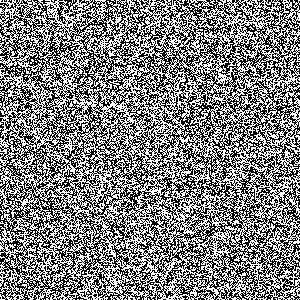

In [19]:
from PIL import Image

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * .5 * 255))

display_spin_field(random_spin_field(300, 300))

### Модель Изинга

In [25]:
def ising_step(field, beta = .4):
    N, M = field.shape
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                     _ising_update(field, n, m, beta)
    return(field)

def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range (n - 1, n + 2):
        for j in range(m - 1, m + 2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    dE = 2 * field[n, m] * total + .2 * field[n, m]
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

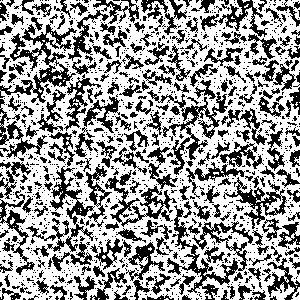

In [74]:
display_spin_field(ising_step(random_spin_field(300, 300)))

### Анимация

In [11]:
from ipywidgets import interact

def display_ising_sequance(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [12]:
images = [random_spin_field(200, 200)]
for i in range(50):
    images.append(ising_step(images[-1].copy()))
    
display_ising_sequance(images)

NameError: name 'ising_step' is not defined

In [13]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [24]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, beta = .4, float h = .1):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                     _cy_ising_update(field, n, m, beta, h)
    return np.array(field)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta, float h):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    if n > 0:
        total += field[n - 1, m]
    if n < N - 1:
        total += field[n + 1, m]
    if m > 0:
        total += field[n, m - 1]
    if m < M - 1:
        total += field[n, m + 1]
    if n > 0 and m > 0:
        total += field[n - 1, m - 1]
    if n < N - 1 and m < M - 1:
        total += field[n + 1, m + 1]
    if m > 0 and n < N - 1:
        total += field[n + 1, m - 1]
    if m < M - 1 and n > 0:
        total += field[n - 1, m + 1]
    cdef float dE = 2 * field[n, m] * total + h * field[n, m]
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

In [26]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

452 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
823 µs ± 3.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
import ipywidgets as widgets

def display_ising_sequance(images):
    def _show(frame=(0, len(images) - 1)):
        print (np.average(images[frame]))
        return display_spin_field(images[frame])
    return interact(_show)

In [29]:
images = [random_spin_field(500, 500)]
for i in range(450):
    images.append(cy_ising_step(images[-1].copy()))
    
display_ising_sequance(images)

interactive(children=(IntSlider(value=225, description='frame', max=450), Output()), _dom_classes=('widget-int…

<function __main__.display_ising_sequance.<locals>._show(frame=(0, 450))>